# Capstone Project - The Battle of the Neighbourhoods

Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

India is the seventh-largest country by area, the second-most populous country, and the most populous democracy in the world. India has very rich cultural heritage dating back to 6500 BCE. Since India achieved its independence in 1947, the country is making a constant progress in all areas. Indians have travelled across the world and have taken their culture to those countries. Indian diaspora is actively engaged, contributing significantly to local development and relationship with India. Many Indians travel to different places across. Indian cuisine is now popular all over.

Canada is home to the world's tenth largest Indian diaspora. The Indo-Canadian population according to the Census 2016 is 1,374,710 (3.9%). Toronto is an international center of business, finance, arts, and culture, and is recognized as one of the most multicultural and cosmopolitan cities in the world. 10.4% of Indian diaspora in Canada, live in the City of Toronto.

There are many Indian restaurants in the City of Toronto to cater to people of South Asian origin, travelers from India and other South Asian countries and people who like Indian Cuisine. As per research by Restaurants Canada, In 2020, commercial foodservice sales will improve slightly with a 4.0% nominal increase, and by 2021, combined commercial and non-commercial foodservice sales are forecast to surpass the $100-billion mark.

Many factors are required to run successful restaurants - a good location, consistent clientele, great chef, great menu, comfortable décor, good customer service, and such.

The objective of this project is to determine suitable locations in Toronto to start a new Indian Restaurant using Machine learning utilizing census, demographic data and location, type information of other businesses.

Sources: 

* Wikipedia website (https://en.wikipedia.org/wiki/Indo-Canadians), 
* Restaurants Canada website (https://www.restaurantscanada.org/resources/foodservice-industry-forecast/)

## Data <a name="data"></a>

The following data sources will be utilized in finding suitable neighbourhood in the City of Toronto.

* The Neighbourhood data from https://open.toronto.ca/dataset/neighbourhoods/
* The Neighbourhood Profiles data from https://open.toronto.ca/dataset/neighbourhood-profiles/ 
* Venue data related to restaurants in the neighbourhoods using Foursquare API https://foursquare.com/

The Neighbourhood data consists of the boundaries of City of Toronto Neighbourhoods. The data is packaged as GeoJSON file with projection as WGS84. The data includes features such as AREA_CODE, AREA_NAME, LATITUDE, LONGITUDE, and geometry. This is used to get a list of neighbourhoods in the City of Toronto and display neighbourhood boundaries in geo map.

The Neighbourhood Profiles data consists of demographic, social and economic characteristics of the people and households in each neighbourhood. The data includes census, age and sex, families and households, language, immigration and internal migration, ethnocultural diversity, Aboriginal peoples, housing, education, income, and labour. For the purpose of this project, the following data is used - Population, Average Income.

Foursquare - a location technology platform, provides data related to location and venues across the world. The Foursquare API is used to get a list of Restaurants in each neighbourhood in the City of Toronto. The geo location data from Neighbourhood data is used to query venues using the Foursquare API. The venue data incldues Venue Category, Venue Name, Venue Latitude, and Venue Longitude.

The data from different sources is analyzed to understand the key characteristics (i.e. exploratory data analysis). The demographic data (Population and Average Income) and venues data is merged to create a unified data set. The unified data set is further analyzed using "K-Nearest Neighbor" machine learning algorithm to classify neighbourhoods into different sets based on similarity. The sets are analyzed to find out suitable neighbourhoods to start a new Indian restaurant.

## Methodology <a name="methodology"></a>

In [1]:
# The code was removed by Watson Studio for sharing.

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests # to send HTTP requests
import json
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from sklearn import preprocessing
from sklearn.cluster import KMeans # for k-means clustering analysis

# import map rendering library
try:
    import folium 
except:
    !conda install folium -c conda-forge
    import folium 

print('Libraries imported.')

Libraries imported.


### Get Demographic Data of Neighbourhoods in City of Toronto

The City Governament of Toronto has published the data about the city collected by its agencies in the Open Data Portal (https://open.toronto.ca/). Through the open data portal, the City governement hopes to the City more transparent, accountable, participatory and accessible.

From the Open Data Portal, download the Neighbourhood Profiles dataset (https://open.toronto.ca/dataset/neighbourhood-profiles/). The Neighbourhood Profiles provide a portrait of the demographic, social and economic characteristics of the people and households in each City of Toronto neighbourhood. The data is based on tabulations of 2016 Census of Population data from Statistics Canada. The dataset is in Comma Seperated Values format.

From the dataset, extract the relavant fields for this study:
* Neighbourhood (Name)
* Neighbourhood Number 
* Population (2016)
* Population density per square kilometre
* Land area in square kilometres
* Average income ($)

In [3]:
# Read the CSV data file from the object storage into a pandas DataFrame
my_file = project.get_file("neighbourhood-profiles-2016-csv.csv")

df = pd.read_csv(my_file)

print("Shape: ", df.shape)
df.head()

Shape:  (2383, 146)


_id                   Category                      Topic  \
0    1  Neighbourhood Information  Neighbourhood Information   
1    2  Neighbourhood Information  Neighbourhood Information   
2    3                 Population   Population and dwellings   
3    4                 Population   Population and dwellings   
4    5                 Population   Population and dwellings   

                      Data Source               Characteristic  \
0                 City of Toronto         Neighbourhood Number   
1                 City of Toronto         TSNS2020 Designation   
2  Census Profile 98-316-X2016001             Population, 2016   
3  Census Profile 98-316-X2016001             Population, 2011   
4  Census Profile 98-316-X2016001  Population Change 2011-2016   

  City of Toronto Agincourt North Agincourt South-Malvern West  \
0             NaN             129                          128   
1             NaN  No Designation               No Designation   
2       2,731,571          29,113                       23,757   
3       2,615,060          30,279                       21,988   
4           4.50%          -3.90%                        8.00%   

        Alderwood           Annex  ... Willowdale West  \
0              20              95  ...              37   
1  No Designation  No Designation  ...  No Designation   
2          12,054          30,526  ...          16,936   
3          11,904          29,177  ...          15,004   
4           1.30%           4.60%  ...          12.90%   

  Willowridge-Martingrove-Richview  Woburn Woodbine Corridor Woodbine-Lumsden  \
0                                7     137                64               60   
1                   No Designation     NIA    No Designation   No Designation   
2                           22,156  53,485            12,541            7,865   
3                           21,343  53,350            11,703            7,826   
4                            3.80%   0.30%             7.20%            0.50%   

         Wychwood  Yonge-Eglinton  Yonge-St.Clair York University Heights  \
0              94             100              97                      27   
1  No Designation  No Designation  No Designation                     NIA   
2          14,349          11,817          12,528                  27,593   
3          13,986          10,578          11,652                  27,713   
4           2.60%          11.70%           7.50%                  -0.40%   

       Yorkdale-Glen Park  
0                      31  
1  Emerging Neighbourhood  
2                  14,804  
3                  14,687  
4                   0.80%  

[5 rows x 146 columns]

In [4]:
# Extract required fields
neighbourhood_profiles = pd.DataFrame(columns=df.columns).copy()

values = {'Characteristic': ['Neighbourhood Number', 'Population, 2016', 'Population density per square kilometre', 'Land area in square kilometres', 'Total income: Average amount ($)'] }
row_mask = df.isin(values).any(1)
neighbourhood_profiles = df[row_mask].copy()
neighbourhood_profiles.reset_index(inplace = True, drop = True)

# remove unwanted columns
neighbourhood_profiles.drop(columns=['_id','Category','Topic','Data Source','City of Toronto'], inplace=True)

neighbourhood_profiles = neighbourhood_profiles.transpose()
neighbourhood_profiles.reset_index(inplace = True)
neighbourhood_profiles.columns=['Neighbourhood', 'Neighbourhood Number', 'Population (2016)', 'Population density per square kilometre', 'Land area in square kilometres', 'Average income ($)']
neighbourhood_profiles.drop(neighbourhood_profiles[neighbourhood_profiles['Neighbourhood'] == 'Characteristic'].index , inplace=True)

# convert numeric text to values 
numeric_columns = ['Population (2016)', 'Population density per square kilometre', 'Land area in square kilometres', 'Average income ($)']
for column in numeric_columns:
    neighbourhood_profiles[column] = neighbourhood_profiles[column].str.replace(r'[^\w.\s]+', '')
    neighbourhood_profiles[column] = neighbourhood_profiles[column].apply(pd.to_numeric, errors='ignore')
    
# convert 'Neighbourhood Number' to 3 digit string format to match AREA_SHORT_CODE in geojson file.
neighbourhood_profiles['Neighbourhood Number'] = neighbourhood_profiles['Neighbourhood Number'].apply(pd.to_numeric, errors='ignore')

print("Shape: ", neighbourhood_profiles.shape)
neighbourhood_profiles.head()

Shape:  (140, 6)


Neighbourhood  Neighbourhood Number  Population (2016)  \
1               Agincourt North                   129              29113   
2  Agincourt South-Malvern West                   128              23757   
3                     Alderwood                    20              12054   
4                         Annex                    95              30526   
5             Banbury-Don Mills                    42              27695   

   Population density per square kilometre  Land area in square kilometres  \
1                                     3929                            7.41   
2                                     3034                            7.83   
3                                     2435                            4.95   
4                                    10863                            2.81   
5                                     2775                            9.98   

   Average income ($)  
1               30414  
2               31825  
3               47709  
4              112766  
5               67757

### Get Boundaries of City of Toronto Neighbourhoods

From the Open Data Portal, download the Neighbourhood dataset (https://open.toronto.ca/dataset/neighbourhoods/). The Neighbourhoods dataset provide the boundary of each Neighbourhood of the City of Toronto. This data can be used to display on a map. The dataset is in GeoJSON format with WGS84 project format.

From the dataset, extract the relavant fields for this study:
* AREA_LONG_CODE
* AREA_NAME	
* LONGITUDE	
* LATITUDE	
* geometry

In [5]:
# Read the geojson data file from the object storage
my_file = project.get_file("Neighbourhoods.geojson")

neighbourhood_boundaries = json.loads(my_file.read())
#neighbourhood_boundaries['features'][0]['geometry'] #Your first point

In [6]:
# convert geojson to dataframe
df = json_normalize(neighbourhood_boundaries['features'])

neighbourhoods_geo = df[['properties.AREA_LONG_CODE', 'properties.AREA_NAME', 'properties.LATITUDE', 'properties.LONGITUDE']].copy()
neighbourhoods_geo.columns=['AREA_CODE', 'AREA_NAME', 'LATITUDE', 'LONGITUDE']

neighbourhoods_geo['AREA_NAME'] = neighbourhoods_geo['AREA_NAME'].str.replace(r'[(\d\+.)$]', '') # clean up: remove AREA_CODE suffix from AREA_NAME

print("Shape: ", neighbourhoods_geo.shape)
neighbourhoods_geo.head()

Shape:  (140, 4)


AREA_CODE                 AREA_NAME   LATITUDE  LONGITUDE
0         94                 Wychwood   43.676919 -79.425515
1        100           Yonge-Eglinton   43.704689 -79.403590
2         97            Yonge-StClair   43.687859 -79.397871
3         27  York University Heights   43.765736 -79.488883
4         31       Yorkdale-Glen Park   43.714672 -79.457108

### Exploratory Data Analysis

Explore the data through discriptive statistics and histogram plots to understand the data. Through exploratory data analysis, we find the number of data points, mean and dispersion of each attribute. Through histogram, we find the number / distribution of neighbourhoods based on the paramenters - Population and Average Income.

In [7]:
# display Descriptive Statistics of the demographic data 
columns = ['Population (2016)', 'Average income ($)']

neighbourhood_profiles[columns].describe()

Population (2016)  Average income ($)
count         140.000000          140.000000
mean        19511.221429        55248.492857
std         10033.589222        38738.594546
min          6577.000000        25989.000000
25%         12019.500000        33476.750000
50%         16749.500000        44566.500000
75%         23854.500000        56654.250000
max         65913.000000       308010.000000

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5d600e19b0>,
      dtype=object)

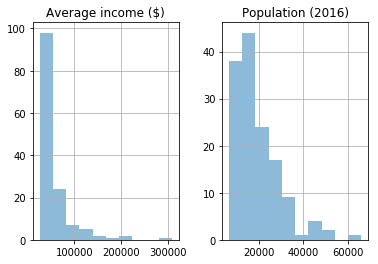

In [8]:
# display histogram to know distribution of the demographic data
columns = ['Population (2016)', 'Average income ($)']

neighbourhood_profiles[columns].hist(alpha=0.5, bins=10) # TODO: add y-label, title

From the Descriptive Statistics, we know there are 140 neighbourhoods in City of Toronto. There are no missing data.

The histogram of population and average income show the Pareto Distribution - a right skewed distribution that has long tail. This means the Population and Average Income are not distributed equally across the city.

### Data Visualization

Display the color coded neighbourhoods on a map to know the spatial layout based on paramters - Population and Average Income. Display and analyze characteristics of the Top 10 neighbourhoods for each parameter.

**Display map of Neighbourhoods based on Population**

In [9]:
# create map of Toronto with neighbourhood color coded on population
toronto_latlon = [43.653963, -79.387207]
m = folium.Map(location=toronto_latlon, zoom_start=11)

folium.Choropleth(
    geo_data=neighbourhood_boundaries,
    name='Neighbourhood',
    data=neighbourhood_profiles,
    columns=['Neighbourhood Number', 'Population (2016)'],
    key_on='feature.properties.AREA_SHORT_CODE',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Neighbourhood by Population'
).add_to(m)

folium.LayerControl().add_to(m)

m

**Top 10 Neighbourhoods by Population**

In [10]:
# print top 10 neighbourhoods by population
neighbourhood_profiles.nlargest(10, 'Population (2016)')

Neighbourhood  Neighbourhood Number  \
123    Waterfront Communities-The Island                    77   
133                               Woburn                   137   
130                      Willowdale East                    51   
106                                Rouge                   131   
67                            L'Amoreaux                   117   
59            Islington-City Centre West                    14   
74                               Malvern                   132   
33   Dovercourt-Wallace Emerson-Junction                    93   
34                  Downsview-Roding-CFB                    26   
96                     Parkwoods-Donalda                    45   

     Population (2016)  Population density per square kilometre  \
123              65913                                     8943   
133              53485                                     4345   
130              50434                                    10087   
106              46496                                     1260   
67               43993                                     6144   
59               43965                                     2712   
74               43794                                     4948   
33               36625                                     9819   
34               35052                                     2337   
96               34805                                     4691   

     Land area in square kilometres  Average income ($)  
123                            7.37               70600  
133                           12.31               30878  
130                            5.00               45326  
106                           36.89               39556  
67                             7.16               31826  
59                            16.21               52787  
74                             8.85               29573  
33                             3.73               39740  
34                            15.00               34168  
96                             7.42               42516

**Display map of Neighbourhoods based on Average Income**

In [11]:
# create map of Toronto with neighbourhood color coded on Average Income
toronto_latlon = [43.653963, -79.387207]
m = folium.Map(location=toronto_latlon, zoom_start=11)

folium.Choropleth(
    geo_data=neighbourhood_boundaries,
    name='Neighbourhood',
    data=neighbourhood_profiles,
    columns=['Neighbourhood Number', 'Average income ($)'],
    key_on='feature.properties.AREA_SHORT_CODE',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Neighbourhood by Average Income'
).add_to(m)

folium.LayerControl().add_to(m)

m

**Top 10 Neighbourhoods by Avearge Income**

In [12]:
# print top 10 neighbourhoods by Average income
neighbourhood_profiles.nlargest(10, 'Average income ($)')

Neighbourhood  Neighbourhood Number  \
17   Bridle Path-Sunnybrook-York Mills                    41   
105                Rosedale-Moore Park                    98   
45                   Forest Hill South                   101   
70                 Lawrence Park South                   103   
22                           Casa Loma                    96   
65                      Kingsway South                    15   
71                  Leaside-Bennington                    56   
10                Bedford Park-Nortown                    39   
138                     Yonge-St.Clair                    97   
4                                Annex                    95   

     Population (2016)  Population density per square kilometre  \
17                9266                                     1040   
105              20923                                     4500   
45               10732                                     4380   
70               15179                                     4685   
22               10968                                     5683   
65                9271                                     3593   
71               16828                                     3596   
10               23236                                     4209   
138              12528                                    10708   
4                30526                                    10863   

     Land area in square kilometres  Average income ($)  
17                             8.91              308010  
105                            4.65              207903  
45                             2.45              204521  
70                             3.24              169203  
22                             1.93              165047  
65                             2.58              144642  
71                             4.68              125564  
10                             5.52              123077  
138                            1.17              114174  
4                              2.81              112766

### Get the Restaurants in the City of Toronto

Use Foursqaure API to get the venues of interest (Restaurants) in the City of Toronto. The Foursquare API explore() is used to query the venues. The parameters for each search are - Top Level Category 'Food', lat-lon of neighbourhood and radius to search. The API returns the list of venues with attributes - Venue Name, Venue Category, Venue Latitude, Venue Longitude. The Venue data of Neighbourhoods is accumulated into a dataset. Duplicate venues are removed to get the final list of Restaurants.

In [13]:
# The code was removed by Watson Studio for sharing.

In [14]:
# create a function to explore all the Neighbourhood in Toronto
LIMIT = 500
CATEGORY_ID = '4d4b7105d754a06374d81259'  # Food - Top level category
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            CATEGORY_ID)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood Number', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
# get nearby venues in toronto Neighbourhoods
toronto_venues = getNearbyVenues(names=neighbourhoods_geo['AREA_CODE'],
                                   latitudes=neighbourhoods_geo['LATITUDE'],
                                   longitudes=neighbourhoods_geo['LONGITUDE']
                                  )

# remove duplicates if any
toronto_venues.drop_duplicates(subset=['Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category'], inplace=True)

print(toronto_venues.shape)
toronto_venues.head()

(2832, 7)


Neighbourhood Number  Neighbourhood Latitude  Neighbourhood Longitude  \
0                    94               43.676919               -79.425515   
1                    94               43.676919               -79.425515   
2                    94               43.676919               -79.425515   
3                    94               43.676919               -79.425515   
4                    94               43.676919               -79.425515   

              Venue  Venue Latitude  Venue Longitude      Venue Category  
0  Pukka Restaurant       43.681055       -79.429187   Indian Restaurant  
1    The Stockyards       43.681570       -79.426210           BBQ Joint  
2        CocoaLatte       43.681768       -79.425158                Café  
3    Ferro Bar Cafe       43.681080       -79.428570  Italian Restaurant  
4   Baker and Scone       43.681614       -79.426075                Café

**Explore the data returned by Foursquare API**

In [16]:
# find out the number of venues returned
print('There are {} number of Restaurants'.format(toronto_venues['Venue'].count()))

# find out how many unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 2832 number of Restaurants
There are 115 uniques categories.


**Extract Total Restaurants and number of Indian Restaurants in each Neighbourhood**

In [17]:
# Extract the total number of restaurants and number of 'Indian Restaurants' in each Neighbourhood
df = toronto_venues.groupby(['Neighbourhood Number', 'Venue Category'], as_index=False).size().unstack(fill_value=0)
df['Total Venues'] = df.sum(axis=1)
df = df.reset_index()

left = neighbourhood_profiles[['Neighbourhood', 'Neighbourhood Number', 'Population (2016)', 'Average income ($)']]
right = df[['Neighbourhood Number', 'Total Venues','Indian Restaurant']]
neighbourhood_profiles = pd.merge(left, right, how='left', left_on='Neighbourhood Number', right_on='Neighbourhood Number')
neighbourhood_profiles.fillna(0, inplace=True)

print('Shape: ', neighbourhood_profiles.shape)
neighbourhood_profiles

Shape:  (140, 6)


Neighbourhood  Neighbourhood Number  \
0                      Agincourt North                   129   
1         Agincourt South-Malvern West                   128   
2                            Alderwood                    20   
3                                Annex                    95   
4                    Banbury-Don Mills                    42   
5                       Bathurst Manor                    34   
6                  Bay Street Corridor                    76   
7                      Bayview Village                    52   
8                Bayview Woods-Steeles                    49   
9                 Bedford Park-Nortown                    39   
10             Beechborough-Greenbrook                   112   
11                             Bendale                   127   
12               Birchcliffe-Cliffside                   122   
13                         Black Creek                    24   
14                         Blake-Jones                    69   
15                Briar Hill-Belgravia                   108   
16   Bridle Path-Sunnybrook-York Mills                    41   
17                     Broadview North                    57   
18                 Brookhaven-Amesbury                    30   
19    Cabbagetown-South St. James Town                    71   
20                  Caledonia-Fairbank                   109   
21                           Casa Loma                    96   
22              Centennial Scarborough                   133   
23               Church-Yonge Corridor                    75   
24                 Clairlea-Birchmount                   120   
25                        Clanton Park                    33   
26                          Cliffcrest                   123   
27              Corso Italia-Davenport                    92   
28                            Danforth                    66   
29                  Danforth East York                    59   
..                                 ...                   ...   
110                    South Riverdale                    70   
111               St.Andrew-Windfields                    40   
112                            Steeles                   116   
113                Stonegate-Queensway                    16   
114             Tam O'Shanter-Sullivan                   118   
115                      Taylor-Massey                    61   
116                        The Beaches                    63   
117       Thistletown-Beaumond Heights                     3   
118                   Thorncliffe Park                    55   
119                  Trinity-Bellwoods                    81   
120                         University                    79   
121                   Victoria Village                    43   
122  Waterfront Communities-The Island                    77   
123                          West Hill                   136   
124             West Humber-Clairville                     1   
125                Westminster-Branson                    35   
126                             Weston                   113   
127                 Weston-Pelham Park                    91   
128                   Wexford/Maryvale                   119   
129                    Willowdale East                    51   
130                    Willowdale West                    37   
131   Willowridge-Martingrove-Richview                     7   
132                             Woburn                   137   
133                  Woodbine Corridor                    64   
134                   Woodbine-Lumsden                    60   
135                           Wychwood                    94   
136                     Yonge-Eglinton                   100   
137                     Yonge-St.Clair                    97   
138            York University Heights                    27   
139                 Yorkdale-Glen Park                    31   

     Population (2016)  Average income ($)  Total Venues

In [18]:
print('There are {} Restaurants'.format(neighbourhood_profiles['Total Venues'].sum()))
print('There are {} Indian Restaurants'.format(neighbourhood_profiles['Indian Restaurant'].sum()))

There are 2832.0 Restaurants
There are 71.0 Indian Restaurants


## Analysis <a name="analysis"></a>

We will use Machine Learning algorithm to classify the neighbourhoods based on similarity given the demographics data (Population and Average Income) and Venue Categories. we will use K-Nearest Neighbor(KNN). 

### Preprocessing

The parameter "Venue Category" is categorical data. It cannot be used directly in machine learning. Use one hot encoding to convert to a suitable format for processing. The data is grouped by neighbourhood and sorted to get the top 10 venues by neighbourhood.

In [19]:
# one hot encoding of Venues Category
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add Neighbourhood column back to dataframe
toronto_onehot['Neighbourhood Number'] = toronto_venues['Neighbourhood Number'] 

# move Neighbourhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

print("shape: ", toronto_onehot.shape)
toronto_onehot.head()

shape:  (2832, 116)


Neighbourhood Number  Afghan Restaurant  African Restaurant  \
0                    94                  0                   0   
1                    94                  0                   0   
2                    94                  0                   0   
3                    94                  0                   0   
4                    94                  0                   0   

   American Restaurant  Arepa Restaurant  Argentinian Restaurant  \
0                    0                 0                       0   
1                    0                 0                       0   
2                    0                 0                       0   
3                    0                 0                       0   
4                    0                 0                       0   

   Asian Restaurant  BBQ Joint  Bagel Shop  Bakery  ...  Tapas Restaurant  \
0                 0          0           0       0  ...                 0   
1                 0          1           0       0  ...                 0   
2                 0          0           0       0  ...                 0   
3                 0          0           0       0  ...                 0   
4                 0          0           0       0  ...                 0   

   Tex-Mex Restaurant  Thai Restaurant  Theme Restaurant  Tibetan Restaurant  \
0                   0                0                 0                   0   
1                   0                0                 0                   0   
2                   0                0                 0                   0   
3                   0                0                 0                   0   
4                   0                0                 0                   0   

   Turkish Restaurant  Udon Restaurant  Vegetarian / Vegan Restaurant  \
0                   0                0                              0   
1                   0                0                              0   
2                   0                0                              0   
3                   0                0                              0   
4                   0                0                              0   

   Vietnamese Restaurant  Wings Joint  
0                      0            0  
1                      0            0  
2                      0            0  
3                      0            0  
4                      0            0  

[5 rows x 116 columns]

In [20]:
# group rows by Neighbourhood and by taking the mean of the frequency of occurrence of each category
toronto_grouped = toronto_onehot.groupby('Neighbourhood Number').mean().reset_index()

print("shape: ", toronto_grouped.shape)
toronto_grouped.head()

shape:  (136, 116)


Neighbourhood Number  Afghan Restaurant  African Restaurant  \
0                     1                0.0                 0.0   
1                     2                0.0                 0.0   
2                     3                0.0                 0.0   
3                     4                0.0                 0.0   
4                     5                0.0                 0.0   

   American Restaurant  Arepa Restaurant  Argentinian Restaurant  \
0             0.071429               0.0                     0.0   
1             0.000000               0.0                     0.0   
2             0.100000               0.0                     0.0   
3             0.000000               0.0                     0.0   
4             0.000000               0.0                     0.0   

   Asian Restaurant  BBQ Joint  Bagel Shop    Bakery  ...  Tapas Restaurant  \
0               0.0        0.0         0.0  0.071429  ...               0.0   
1               0.0        0.0         0.0  0.000000  ...               0.0   
2               0.1        0.0         0.0  0.100000  ...               0.0   
3               0.0        0.0         0.0  0.200000  ...               0.0   
4               0.0        0.0         0.0  0.000000  ...               0.0   

   Tex-Mex Restaurant  Thai Restaurant  Theme Restaurant  Tibetan Restaurant  \
0                 0.0              0.0               0.0                 0.0   
1                 0.0              0.0               0.0                 0.0   
2                 0.0              0.1               0.0                 0.0   
3                 0.0              0.0               0.0                 0.0   
4                 0.0              0.0               0.0                 0.0   

   Turkish Restaurant  Udon Restaurant  Vegetarian / Vegan Restaurant  \
0                 0.0              0.0                            0.0   
1                 0.0              0.0                            0.0   
2                 0.0              0.0                            0.0   
3                 0.0              0.0                            0.0   
4                 0.0              0.0                            0.0   

   Vietnamese Restaurant  Wings Joint  
0                    0.0          0.0  
1                    0.0          0.0  
2                    0.0          0.0  
3                    0.0          0.0  
4                    0.0          0.0  

[5 rows x 116 columns]

In [21]:
# write a function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [22]:
# create the new dataframe and display the top 10 venues for each Neighbourhood.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood Number']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood Number'] = toronto_grouped['Neighbourhood Number']

for ind in np.arange(toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

print("shape: ", neighbourhoods_venues_sorted.shape)
neighbourhoods_venues_sorted.head()

shape:  (136, 11)


Neighbourhood Number 1st Most Common Venue 2nd Most Common Venue  \
0                     1        Sandwich Place            Restaurant   
1                     2           Pizza Place      Sushi Restaurant   
2                     3     Indian Restaurant  Caribbean Restaurant   
3                     4           Pizza Place        Sandwich Place   
4                     5     Fish & Chips Shop            Restaurant   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                Bakery            Food Court           Pizza Place   
1   Japanese Restaurant        Sandwich Place  Caribbean Restaurant   
2           Pizza Place   American Restaurant      Asian Restaurant   
3                Bakery  Fast Food Restaurant           Wings Joint   
4        Sandwich Place   Fried Chicken Joint  Fast Food Restaurant   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0  Fast Food Restaurant      Swiss Restaurant    Chinese Restaurant   
1   Fried Chicken Joint     Fish & Chips Shop      Doner Restaurant   
2       Thai Restaurant                Bakery           Wings Joint   
3                  Food      Doner Restaurant            Donut Shop   
4           Wings Joint                 Diner      Doner Restaurant   

      9th Most Common Venue       10th Most Common Venue  
0  Mediterranean Restaurant          Japanese Restaurant  
1                Donut Shop          Dumpling Restaurant  
2        Falafel Restaurant            Fish & Chips Shop  
3       Dumpling Restaurant  Eastern European Restaurant  
4                Donut Shop          Dumpling Restaurant

### Feature selection/extraction

Select the paramters to be used for machine leaning classification. The paramters are normalized to remove bias of one/more paramters. Post normalization, each paramter will have range of 0 to 1.

The parameters selected for classification are:

* Population
* Average Income
* Restaurant Type

In [23]:
# lets define feature set
feature = neighbourhood_profiles[['Population (2016)', 'Average income ($)']]

print("Shape:", feature.shape)
feature.head()

Shape: (140, 2)


Population (2016)  Average income ($)
0              29113               30414
1              23757               31825
2              12054               47709
3              30526              112766
4              27695               67757

In [24]:
# normalize the data
from sklearn import preprocessing

# 1.convert the column value of the dataframe as floats
x = feature.values.astype(float)

# 2. create a min max processing object
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

# 3. convert the scaled array to dataframe
feature_normalized = pd.DataFrame(x_scaled)
feature_normalized.columns = ['Population (2016)', 'Average income ($)']

print("Shape: ", feature_normalized.shape)
feature_normalized.nlargest(10,'Average income ($)')

Shape:  (140, 2)


Population (2016)  Average income ($)
16            0.045318            1.000000
104           0.241776            0.645037
44            0.070025            0.633045
69            0.144971            0.507813
21            0.074002            0.493077
64            0.045402            0.420724
70            0.172762            0.353077
9             0.280757            0.344258
137           0.100293            0.312689
3             0.403617            0.307697

In [25]:
# merge normalized demographic data and onehot encoded venue for the neighbouhood 
feature_normalized = feature_normalized.join(toronto_grouped.set_index('Neighbourhood Number'))
feature_normalized.fillna(0, inplace=True)

print("Shape: ", feature_normalized.shape)
feature_normalized.head()

Shape:  (140, 117)


Population (2016)  Average income ($)  Afghan Restaurant  \
0           0.379803            0.015690                0.0   
1           0.289538            0.020693                0.0   
2           0.092305            0.077016                0.0   
3           0.403617            0.307697                0.0   
4           0.355905            0.148102                0.0   

   African Restaurant  American Restaurant  Arepa Restaurant  \
0                 0.0             0.000000               0.0   
1                 0.0             0.071429               0.0   
2                 0.0             0.000000               0.0   
3                 0.0             0.100000               0.0   
4                 0.0             0.000000               0.0   

   Argentinian Restaurant  Asian Restaurant  BBQ Joint  Bagel Shop  ...  \
0                     0.0               0.0        0.0         0.0  ...   
1                     0.0               0.0        0.0         0.0  ...   
2                     0.0               0.0        0.0         0.0  ...   
3                     0.0               0.1        0.0         0.0  ...   
4                     0.0               0.0        0.0         0.0  ...   

   Tapas Restaurant  Tex-Mex Restaurant  Thai Restaurant  Theme Restaurant  \
0               0.0                 0.0              0.0               0.0   
1               0.0                 0.0              0.0               0.0   
2               0.0                 0.0              0.0               0.0   
3               0.0                 0.0              0.1               0.0   
4               0.0                 0.0              0.0               0.0   

   Tibetan Restaurant  Turkish Restaurant  Udon Restaurant  \
0                 0.0                 0.0              0.0   
1                 0.0                 0.0              0.0   
2                 0.0                 0.0              0.0   
3                 0.0                 0.0              0.0   
4                 0.0                 0.0              0.0   

   Vegetarian / Vegan Restaurant  Vietnamese Restaurant  Wings Joint  
0                            0.0                    0.0          0.0  
1                            0.0                    0.0          0.0  
2                            0.0                    0.0          0.0  
3                            0.0                    0.0          0.0  
4                            0.0                    0.0          0.0  

[5 rows x 117 columns]

### Classification

We will use K-Nearest Neighbor(KNN) algorithm to classify each neighbourhood into 4 clusters. By trial, 5 is chosen as the best value for k to build the model.

In [26]:
# Run k-means to cluster the Neighbourhood into clusters.
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(feature_normalized)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([3, 0, 1, 3, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 2, 0, 1, 0, 1, 2,
       0, 3, 0, 0, 1, 1, 1, 0, 3, 0, 3, 3, 0, 1, 2, 1, 2, 1, 0, 0, 1, 1,
       2, 3, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 3, 0, 1, 0, 1, 1, 2, 0,
       3, 0, 0, 2, 2, 0, 1, 3, 0, 0, 3, 3, 0, 0, 0, 3, 0, 3, 0, 1, 1, 3,
       0, 1, 1, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 1, 1, 2, 3, 0, 1, 0, 0,
       1, 1, 0, 1, 3, 1, 0, 0, 1, 1, 0, 1, 3, 1, 3, 3, 0, 0, 3, 3, 0, 0,
       3, 0, 0, 0, 1, 0, 3, 0], dtype=int32)

In [27]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each Neighbourhood.
left = neighbourhood_profiles#[['Neighbourhood', 'Neighbourhood Number', 'Population (2016)', 'Average income ($)']]
right = neighbourhoods_geo[['AREA_CODE', 'LATITUDE', 'LONGITUDE']]
neighbourhood_clusters = pd.merge(left, right, left_on='Neighbourhood Number', right_on='AREA_CODE')
neighbourhood_clusters.drop(columns=['AREA_CODE'], inplace=True)

neighbourhood_clusters = pd.merge(neighbourhood_clusters, neighbourhoods_venues_sorted, how='left', left_on='Neighbourhood Number', right_on='Neighbourhood Number')

# add clustering labels
neighbourhood_clusters.insert(0, 'Cluster Labels', kmeans.labels_)
neighbourhood_clusters.astype({"Cluster Labels" : int})

print("Shape: ", neighbourhood_clusters.shape)
neighbourhood_clusters.head()

Shape:  (140, 19)


Cluster Labels                 Neighbourhood  Neighbourhood Number  \
0               3               Agincourt North                   129   
1               0  Agincourt South-Malvern West                   128   
2               1                     Alderwood                    20   
3               3                         Annex                    95   
4               1             Banbury-Don Mills                    42   

   Population (2016)  Average income ($)  Total Venues  Indian Restaurant  \
0              29113               30414          23.0                2.0   
1              23757               31825          42.0                0.0   
2              12054               47709           5.0                0.0   
3              30526              112766          63.0                1.0   
4              27695               67757          22.0                1.0   

    LATITUDE  LONGITUDE 1st Most Common Venue 2nd Most Common Venue  \
0  43.805441 -79.266712    Chinese Restaurant                Bakery   
1  43.788658 -79.265612    Chinese Restaurant      Asian Restaurant   
2  43.604937 -79.541611           Pizza Place            Donut Shop   
3  43.671585 -79.404001                  Café    Italian Restaurant   
4  43.737657 -79.349718           Pizza Place   Japanese Restaurant   

  3rd Most Common Venue          4th Most Common Venue 5th Most Common Venue  \
0     Indian Restaurant          Vietnamese Restaurant  Fast Food Restaurant   
1  Cantonese Restaurant                     Restaurant                Bakery   
2        Sandwich Place            Moroccan Restaurant           Wings Joint   
3     French Restaurant  Vegetarian / Vegan Restaurant        Sandwich Place   
4            Restaurant                           Café  Cantonese Restaurant   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0           Pizza Place        Sandwich Place  Hong Kong Restaurant   
1        Sandwich Place      Malay Restaurant  Caribbean Restaurant   
2    Dim Sum Restaurant      Doner Restaurant   Dumpling Restaurant   
3            Restaurant           Pizza Place    Mexican Restaurant   
4          Burger Joint   American Restaurant     Indian Restaurant   

         9th Most Common Venue     10th Most Common Venue  
0          Japanese Restaurant        Fried Chicken Joint  
1          Shanghai Restaurant         Seafood Restaurant  
2  Eastern European Restaurant        Egyptian Restaurant  
3          American Restaurant                     Bistro  
4           Mexican Restaurant  Middle Eastern Restaurant

### Examine Clusters

Let us examine the clusters to find out the characterticis of Neighbourhoods in them. First, we will plot each cluster based on demographics data i.e. Poputaion and Average Income. We will get descriptive statistics of each cluster. We will then visualize the Neighbourhoods in each cluster on a map to understnad the spatial relationships. These different representations helps us to understand the classification done by the KNN algorithm and identify key characteristics.

**Scatter Plot**

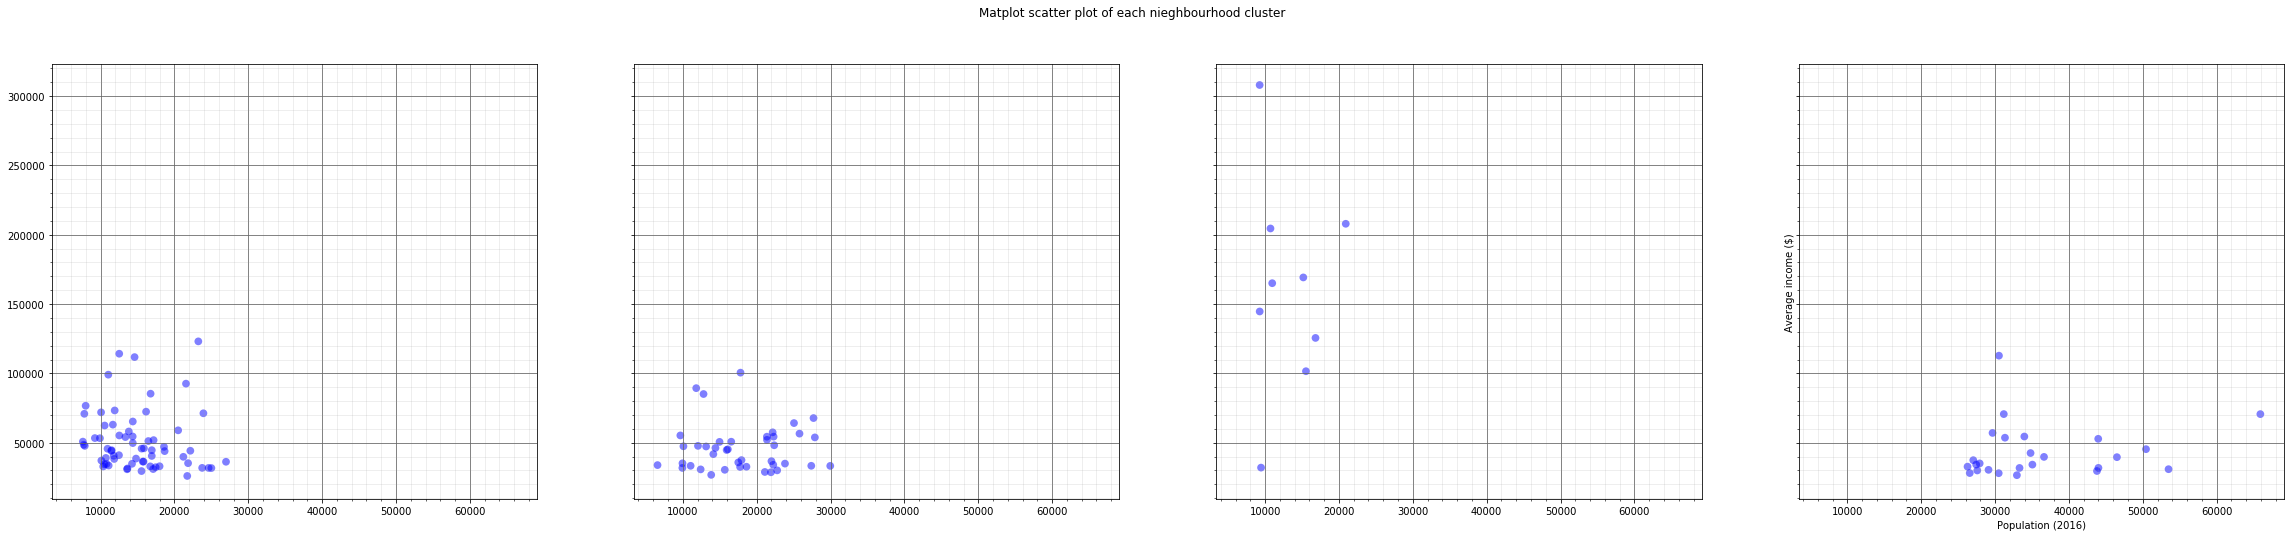

In [28]:
# create scatter plot to analyze classification
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Create the figure and axes objects
fig, ax = plt.subplots(1, kclusters, sharex=True, sharey=True, figsize=(40, 8))
fig.suptitle('Matplot scatter plot of each nieghbourhood cluster') # TODO: add x,y axes labels

# Plot the data
for i in range(0,kclusters):
    df = neighbourhood_clusters[neighbourhood_clusters['Cluster Labels'] == i]
    #print('Cluster', i, ' has ', df['Cluster Labels'].count(), 'data points.')
    x = df['Population (2016)'].to_numpy()
    y = df['Average income ($)'].to_numpy()
    #print(x,y)
    ax[i].scatter(x, y, alpha=0.5, c='Blue', edgecolors='none', s=60)

    # Show the major grid lines with dark grey lines
    ax[i].grid(b=True, which='major', color='#666666', linestyle='-')

    # Show the minor grid lines with very faint and almost transparent grey lines
    ax[i].minorticks_on()
    ax[i].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    #ax[i].set_xlim(left=0,right=)
    #ax[i].set_ylim(bottom=0)

plt.xlabel('Population (2016)')
plt.ylabel('Average income ($)')
plt.show()


**Descriptive Statistics**

In [29]:
# get descriptive statistics of each cluster
cluster_summary = pd.DataFrame(columns=['Cluster Label', 
                                        'Number of Neighbourhoods', 
                                        'Population (min)', 
                                        'Population (max)', 
                                        'Average Income (min)', 
                                        'Average Income (max)', 
                                        'Total Restaurants', 
                                        'Indian Restaurants', 
                                        'Neighbourhoods without Indian Restaurants'])

for i in range(0, kclusters):
    df = neighbourhood_clusters[neighbourhood_clusters['Cluster Labels'] == i]
    t = df[df['Indian Restaurant']==0]
    new_row = {
        'Cluster Label' : i,
        'Number of Neighbourhoods' : df['Neighbourhood Number'].count(),
        'Population (min)' : df['Population (2016)'].min(),
        'Population (max)' : df['Population (2016)'].max(),
        'Average Income (min)' : df['Average income ($)'].min(),
        'Average Income (max)' : df['Average income ($)'].max(),
        'Total Restaurants' : df['Total Venues'].sum(),
        'Indian Restaurants' : df['Indian Restaurant'].sum(),
        'Neighbourhoods without Indian Restaurants' : t['Indian Restaurant'].count()
    }
    cluster_summary = cluster_summary.append(new_row, ignore_index=True)

cluster_summary = cluster_summary.astype('int32')
cluster_summary

Cluster Label  Number of Neighbourhoods  Population (min)  \
0              0                        65              7607   
1              1                        41              6577   
2              2                         9              9266   
3              3                        25             26274   

   Population (max)  Average Income (min)  Average Income (max)  \
0             26984                 25989                123077   
1             29960                 26793                100516   
2             20923                 32012                308010   
3             65913                 26548                112766   

   Total Restaurants  Indian Restaurants  \
0               1379                  33   
1                795                  20   
2                116                   5   
3                542                  13   

   Neighbourhoods without Indian Restaurants  
0                                         48  
1                                         29  
2                                          6  
3                                         17

**Visualize clusters on Map**

In [30]:
# visualize the resulting clusters
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
toronto_latlon = [43.653963, -79.387207]
m = folium.Map(location=toronto_latlon, zoom_start=11)

# Add cluster color coded Nieghbourhood Boundary
folium.Choropleth(
    geo_data=neighbourhood_boundaries,
    name='Neighbourhood Classification',
    data = neighbourhood_clusters,
    columns=['Neighbourhood Number', 'Cluster Labels'],
    key_on='feature.properties.AREA_SHORT_CODE',
    fill_color='YlGn',
    fill_opacity=0.7, 
    line_opacity=0.2,
    bins=(kclusters+1),
    legend_name='Toronto Neighbourhood Classification').add_to(m)

# Add marker for Indian Restaurants
fg = folium.FeatureGroup(name='Indian Restaurants')
venues = toronto_venues[toronto_venues['Venue Category'] == 'Indian Restaurant']
for name, lat, lon, category in zip(venues['Venue'], venues['Venue Latitude'], venues['Venue Longitude'], venues['Venue Category']):
    label = folium.Popup(str(name), parse_html=True)
    folium.Marker(location=[lat, lon], popup=label).add_to(fg)
m.add_child(fg)

folium.LayerControl().add_to(m)
       
m

**Characteristics of Neighbourhoods in Clusters**

Examining the scatter plot and descriptive statistics, we can assume the characteristics of each cluster as follows:

* Cluster 0: Middle-High Income Neighbourhoods, situated around the central region, has highest number of Restaurants
* Cluster 1: Middle-High Income Neighbourhoods, situated around the central region, with moderate number of Restaurants
* Cluster 2: This consists of predominantly high income neighbourhoods, situated in the central region.
* Cluster 3: Highly populous Neighbourhoods with low-mid income levels, with moderate number of Restaurants


### Detailed information about clusters

Display and analyze the data of neighbourhoods in each cluster. Look for range of values of paramters and top 10 venues in each neighbourhood.

**Cluster 0**

In [31]:
df = neighbourhood_clusters[neighbourhood_clusters['Cluster Labels'] == 0]
df.sort_values(by='Population (2016)', ascending=True)

Cluster Labels                     Neighbourhood  Neighbourhood Number  \
120               0                        University                    79   
14                0                       Blake-Jones                    69   
97                0          Playter Estates-Danforth                    67   
134               0                  Woodbine-Lumsden                    60   
65                0                Lambton Baby Point                   114   
93                0                     Old East York                    58   
47                0                         Guildwood                   140   
106               0      Runnymede-Bloor West Village                    89   
74                0                        Maple Leaf                    29   
117               0      Thistletown-Beaumond Heights                     3   
101               0                   Rexdale-Kipling                     4   
75                0                     Markland Wood                    12   
96                0              Pelmo Park-Humberlea                    23   
100               0                       Regent Park                    72   
53                0          Humber Heights-Westmount                     8   
99                0                Princess-Rosethorn                    10   
127               0                Weston-Pelham Park                    91   
84                0                       New Toronto                    18   
17                0                   Broadview North                    57   
19                0  Cabbagetown-South St. James Town                    71   
34                0                    Dufferin Grove                    83   
41                0               Etobicoke West Mall                    13   
88                0                   North Riverdale                    68   
51                0                    Highland Creek                   134   
137               0                    Yonge-St.Clair                    97   
133               0                 Woodbine Corridor                    64   
22                0            Centennial Scarborough                   133   
80                0                      Mount Dennis                   115   
57                0                           Ionview                   125   
94                0           Palmerston-Little Italy                    80   
..              ...                               ...                   ...   
139               0                Yorkdale-Glen Park                    31   
55                0                        Humbermede                    22   
71                0                   Little Portugal                    84   
48                0                        Henry Farm                    53   
98                0                     Pleasant View                    46   
5                 0                    Bathurst Manor                    34   
67                0                  Lansing-Westgate                    38   
25                0                      Clanton Park                    33   
108               0               Scarborough Village                   139   
82                0               Mount Pleasant East                    99   
52                0                 Hillcrest Village                    48   
130               0                   Willowdale West                    37   
61                0                      Kennedy Park                   124   
29                0                Danforth East York                    59   
78                0                       Morningside                   135   
126               0                            Weston                   113   
40                0    Eringate-Centennial-West Deane                    11   
92                0                 O'Connor-Parkview                    54   
79                0                         Moss Park  

**Cluster 1**

In [32]:
df = neighbourhood_clusters[neighbourhood_clusters['Cluster Labels'] == 1]
df.sort_values(by='Population (2016)', ascending=True)

Cluster Labels                  Neighbourhood  Neighbourhood Number  \
10                1        Beechborough-Greenbrook                   112   
28                1                       Danforth                    66   
107               1                         Rustic                    28   
20                1             Caledonia-Fairbank                   109   
72                1                    Long Branch                    19   
60                1       Keelesdale-Eglinton West                   110   
136               1                 Yonge-Eglinton                   100   
2                 1                      Alderwood                    20   
54                1                  Humber Summit                    21   
43                1              Forest Hill North                   102   
8                 1          Bayview Woods-Steeles                    49   
90                1                       Oakridge                   121   
27                1         Corso Italia-Davenport                    92   
46                1              Greenwood-Coxwell                    65   
103               1                   Roncesvalles                    86   
115               1                  Taylor-Massey                    61   
26                1                     Cliffcrest                   123   
85                1               Newtonbrook East                    50   
119               1              Trinity-Bellwoods                    81   
121               1               Victoria Village                    43   
18                1            Brookhaven-Amesbury                    30   
111               1           St.Andrew-Windfields                    40   
62                1           Kensington-Chinatown                    78   
89                1           North St. James Town                    74   
118               1               Thorncliffe Park                    55   
35                1              East End-Danforth                    62   
7                 1                Bayview Village                    52   
42                1                Flemingdon Park                    44   
63                1  Kingsview Village-The Westway                     6   
49                1                High Park North                    88   
102               1              Rockcliffe-Smythe                   111   
12                1          Birchcliffe-Cliffside                   122   
39                1            Englemount-Lawrence                    32   
37                1                  Eglinton East                   138   
86                1               Newtonbrook West                    36   
113               1            Stonegate-Queensway                    16   
6                 1            Bay Street Corridor                    76   
123               1                      West Hill                   136   
4                 1              Banbury-Don Mills                    42   
110               1                South Riverdale                    70   
11                1                        Bendale                   127   

     Population (2016)  Average income ($)  Total Venues  Indian Restaurant  \
10                6577               33829           4.0                0.0   
28                9666               55225          14.0                0.0   
107               9941               31800           9.0                0.0   
20                9955               35112           2.0                0.0   
72               10084               47384          15.0                0.0   
60               11058               33316           8.0                0.0   
136              11817               89330          99.0                2.0   
2                12054               47709           5.0                0.0   
54               12416               30731           5.0                0.0   
43               12806

**Cluster 2**

In [33]:
df = neighbourhood_clusters[neighbourhood_clusters['Cluster Labels'] == 2]
df.sort_values(by='Population (2016)', ascending=True)

Cluster Labels                      Neighbourhood  Neighbourhood Number  \
16                2  Bridle Path-Sunnybrook-York Mills                    41   
64                2                     Kingsway South                    15   
38                2                   Elms-Old Rexdale                     5   
44                2                  Forest Hill South                   101   
21                2                          Casa Loma                    96   
69                2                Lawrence Park South                   103   
36                2           Edenbridge-Humber Valley                     9   
70                2                 Leaside-Bennington                    56   
104               2                Rosedale-Moore Park                    98   

     Population (2016)  Average income ($)  Total Venues  Indian Restaurant  \
16                9266              308010           6.0                0.0   
64                9271              144642          24.0                1.0   
38                9456               32012           5.0                0.0   
44               10732              204521           0.0                0.0   
21               10968              165047          20.0                0.0   
69               15179              169203          10.0                0.0   
36               15535              101551           5.0                1.0   
70               16828              125564          32.0                3.0   
104              20923              207903          14.0                0.0   

      LATITUDE  LONGITUDE 1st Most Common Venue 2nd Most Common Venue  \
16   43.731013 -79.378904                  Café      Sushi Restaurant   
64   43.653520 -79.510577    Italian Restaurant           Pizza Place   
38   43.721519 -79.548983     Fish & Chips Shop            Restaurant   
44   43.694526 -79.414318                   NaN                   NaN   
21   43.681852 -79.408007                  Café    Italian Restaurant   
69   43.717212 -79.406039           Pizza Place                  Café   
36   43.670886 -79.522458     Indian Restaurant   Japanese Restaurant   
70   43.703797 -79.366072     Indian Restaurant        Sandwich Place   
104  43.682820 -79.379669                  Café     French Restaurant   

    3rd Most Common Venue      4th Most Common Venue 5th Most Common Venue  \
16             Restaurant                Pizza Place  Fast Food Restaurant   
64           Burger Joint             Breakfast Spot      Sushi Restaurant   
38         Sandwich Place        Fried Chicken Joint  Fast Food Restaurant   
44                    NaN                        NaN                   NaN   
21                 Bistro  Middle Eastern Restaurant        Sandwich Place   
69     Chinese Restaurant                 Restaurant                 Diner   
36              BBQ Joint                     Bakery  Fast Food Restaurant   
70       Sushi Restaurant                     Bakery           Wings Joint   
104    Italian Restaurant           Asian Restaurant                Bistro   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
16                   Food      Doner Restaurant            Donut Shop   
64                 Bakery     French Restaurant       Thai Restaurant   
38            Wings Joint                 Diner      Doner Restaurant   
44                    NaN                   NaN                   NaN   
21             Donut Shop          Burger Joint      Sushi Restaurant   
69     Mexican Restaurant       Thai Restaurant  Fast Food Restaurant   
36             Food Truck            Donut Shop   Dumpling Restaurant   
70     Mexican Restaurant           Pizza Place      Asian Restaurant   
104                Bakery   American Restaurant           Pizza Place   

           9th Most Common Venue       10th Most Common Venue  
16           Dumpling Restaurant  Eastern European Restaurant  
64                          Café          

**Cluster 3**

In [34]:
df = neighbourhood_clusters[neighbourhood_clusters['Cluster Labels'] == 3]
df.sort_values(by='Population (2016)', ascending=True)

Cluster Labels                        Neighbourhood  \
125               3                  Westminster-Branson   
76                3                             Milliken   
30                3                   Don Valley Village   
114               3               Tam O'Shanter-Sullivan   
138               3              York University Heights   
128               3                     Wexford/Maryvale   
0                 3                      Agincourt North   
83                3                  Mount Pleasant West   
45                3               Glenfield-Jane Heights   
3                 3                                Annex   
87                3                              Niagara   
23                3                Church-Yonge Corridor   
81                3    Mount Olive-Silverstone-Jamestown   
124               3               West Humber-Clairville   
77                3  Mimico (includes Humber Bay Shores)   
95                3                    Parkwoods-Donalda   
33                3                 Downsview-Roding-CFB   
32                3  Dovercourt-Wallace Emerson-Junction   
73                3                              Malvern   
58                3           Islington-City Centre West   
66                3                           L'Amoreaux   
105               3                                Rouge   
129               3                      Willowdale East   
132               3                               Woburn   
122               3    Waterfront Communities-The Island   

     Neighbourhood Number  Population (2016)  Average income ($)  \
125                    35              26274               32724   
76                    130              26572               28085   
30                     47              27051               37379   
114                   118              27446               34200   
138                    27              27593               29958   
128                   119              27917               35047   
0                     129              29113               30414   
83                    104              29658               57039   
45                     25              30491               27984   
3                      95              30526              112766   
87                     82              31180               70623   
23                     75              31340               53583   
81                      2              32954               26548   
124                     1              33312               31771   
77                     17              33964               54438   
95                     45              34805               42516   
33                     26              35052               34168   
32                     93              36625               39740   
73                    132              43794               29573   
58                     14              43965               52787   
66                    117              43993               31826   
105                   131              46496               39556   
129                    51              50434               45326   
132                   137              53485               30878   
122                    77              65913               70600   

     Total Venues  Indian Restaurant   LATITUDE  LONGITUDE  \
125           6.0                0.0  43.778813 -79.452418   
76            8.0                0.0  43.820691 -79.275009   
30           24.0                0.0  43.783294 -79.353644   
114          16.0                0.0  43.780130 -79.302919   
138          15.0                0.0  43.765736 -79.488883   
128          23.0                1.0  43.748572 -79.298637   
0            23.0                2.0  43.805441 -79.266712   
83            2.0                0.0  43.704435 -79.393360   
45            6.0                0.0  43.745636 -79.513465   
3            63.0                1.0  43.671585 -79.404

### Examine Neighbourhood Clusters with Indian Restaurants

In [35]:
neighbourhood_clusters[neighbourhood_clusters['Indian Restaurant'] > 0].sort_values(by='Cluster Labels', ascending=True)

Cluster Labels                        Neighbourhood  \
84                0                          New Toronto   
135               0                             Wychwood   
82                0                  Mount Pleasant East   
79                0                            Moss Park   
94                0              Palmerston-Little Italy   
71                0                      Little Portugal   
108               0                  Scarborough Village   
93                0                        Old East York   
116               0                          The Beaches   
59                0                        Junction Area   
117               0         Thistletown-Beaumond Heights   
31                0                          Dorset Park   
9                 0                 Bedford Park-Nortown   
120               0                           University   
133               0                    Woodbine Corridor   
48                0                           Henry Farm   
88                0                      North Riverdale   
115               1                        Taylor-Massey   
103               1                         Roncesvalles   
102               1                    Rockcliffe-Smythe   
118               1                     Thorncliffe Park   
123               1                            West Hill   
136               1                       Yonge-Eglinton   
11                1                              Bendale   
62                1                 Kensington-Chinatown   
49                1                      High Park North   
89                1                 North St. James Town   
6                 1                  Bay Street Corridor   
4                 1                    Banbury-Don Mills   
70                2                   Leaside-Bennington   
64                2                       Kingsway South   
36                2             Edenbridge-Humber Valley   
3                 3                                Annex   
132               3                               Woburn   
128               3                     Wexford/Maryvale   
87                3                              Niagara   
66                3                           L'Amoreaux   
77                3  Mimico (includes Humber Bay Shores)   
122               3    Waterfront Communities-The Island   
0                 3                      Agincourt North   

     Neighbourhood Number  Population (2016)  Average income ($)  \
84                     18              11463               44101   
135                    94              14349               54460   
82                     99              16775               85340   
79                     73              20506               58915   
94                     80              13826               58071   
71                     84              15559               45737   
108                   139              16724               32913   
93                     58               9233               53315   
116                    63              21567               92580   
59                     90              14366               49709   
117                     3              10360               32815   
31                    126              25003               31692   
9                      39              23236              123077   
120                    79               7607               50757   
133                    64              12541               55199   
48                     53              15723               36359   
88                     68              11916               73253   
115                    61              15683               30430   
103                    86              14974               50580   
102                   111              22246               34059   
118                    55              21108               28875   
123                   136              27392    

In [36]:
# The code was removed by Watson Studio for sharing.

{'file_name': 'neighbourhood_clusters_knn4.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'applieddatasciencecapstone-donotdelete-pr-rkyltbv9jlygzm',
 'asset_id': '25c223aa-7831-4f09-b93d-6cbd9db83de1'}

## Results and Discussion <a name="results"></a>

The K-Nearest Neighbor machine learning algorithm classified each neighbourhoods of the City of Toronto into 5 groups based on the similarities given the demographic data (Population, Average Income and the type/number of Restaurants in each neighbourhood. Based on the classification and the number of Indian Restaurants in each cluster and neighbourhood, a prospective entrepreneur can narrow down to the best possible locations to open an Indian Restaurant. After analyzing the classification and presence of other Indian Restaurants, the recommendation are as follows:

* Cluster 0: Middle-High Income Neighbourhoods, situated around the central region, has highest number of Restaurants

    This cluster has the maximum number of neighbourhoods and highest number of Restaurants. There are 39 Indian Restaurants in this cluster spread across in 20 neighbourhoods. with highest concentration of Indian and other Restaurants, the competition would be high. But there is still an opportunity for a new 4-Star fine dining Indian Restaurant in the 48 neighbourhoods which currently do not have an Indian Restaurant.


* Cluster 1: Middle-High Income Neighbourhoods, situated around the central region, with moderate number of Restaurants

    This cluster of neighbourhoods is like Cluster 0 but with moderate number of Restaurants. This makes it a more favorable choice of location for a new Indian Restaurants. A 3-Star or 4-star fine dining Indian Restaurant.


* Cluster 2: This consists of predominantly high income neighbourhoods, situated in the central region.

    There are 5 Indian Restaurants in this cluster with 3 in the neighbourhood Leaside-Bennington. There are 5 neighbourhoods that are potential locations for opening a new 5-Star, very fine dining Indian Restaurant to cater to the high-end clientele in the neighbourhood.


* Cluster 3: Highly populous Neighbourhoods with low-mid income levels, with moderate number of Restaurants

    This cluster of neighbourhoods is suitable for a 3-Star or 4-star fine dining Indian Restaurant in 17 neighbourhoods that currently do not have an Indian Restaurant.


## Conclusion <a name="conclusion"></a>

The availability of data and improvements in Data Science and Machine Learning is helping in analysis and decision making. In the current study, the data about demographic profiles of neighbourhoods of the City of Toronto and Restaurants data from Foursquare are used in classifying the neighbourhoods in to different clusters using K-Nearest Neighbor algorithm. The clustering helps an entrepreneur in identifying suitable locations to open an Indian Restaurants. It also provides clues to the type of clientele for the restaurant. Armed with this insight the entrepreneur can further investigate other aspects required to open and run a successful business. The analysis and classification can be further be improved by using additional data points such as proximity to major attractions, distance from similar restaurants, ethnicity of the population and tourists, etc.

The clustering algorithm classified the neighbourhoods into 5 clusters. Exploratory analysis of clusters revealed characteristics of neighbourhoods in each cluster. This insight helped in narrowing down to the type of Restaurant that possibly will flourish in the neighbourhood. There was one cluster with only one neighbourhood. It was difficult to identify the rationale for such a classification. There needs to be more research in the area of explainable machine learning and artificial intelligence.
